In [36]:
from cnn_builder import *
from config import *
from dataset_functions import *
from hypercube_set import HypercubeSet
from hypercube_loader import *
import numpy as np
import tensorflow as tf
import tensorflow.keras as tk

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
os.chdir(os.getcwd().split("jupyter")[0])

inf = 2e32

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
hc_set = HypercubeSet(hc_array=load_hypercubes(plot_hc=False, plot_mask=False, n_max_cubes=inf))
hc_set.print_metadata()

Reading media/Mateus_2022/Area01\raw_112_rf.hdr ...
Reading media/Mateus_2022/Area01\raw_1984_rf.hdr ...
Reading media/Mateus_2022/Area01\raw_3904_rf.hdr ...
Reading media/Mateus_2022/Area01\raw_5744_rf.hdr ...
Reading media/Mateus_2022/Area01\raw_7584_rf.hdr ...
Min: 0.006377667188644409, Max: 0.16416394710540771, Size: (1840, 3200, 223)


In [3]:
hc_set.obtain_ground_labels()
hc_set.obtain_train_indices(test_percentage=test_split)

In [4]:
hc_set.standardize()

In [5]:
X_train, y_train = hc_set.split_train(patch_size=patch_size)
y_train = reduce_labels_center(y_train)

|████████████████████████████████████████| 313709/313709 [100%] in 1.6s (196148.75/s)                                   


In [6]:
X_test, y_test = hc_set.split_test(patch_size=patch_size)
y_test = reduce_labels_center(y_test)

|████████████████████████████████████████| 78428/78428 [100%] in 0.3s (254466.14/s)                                     


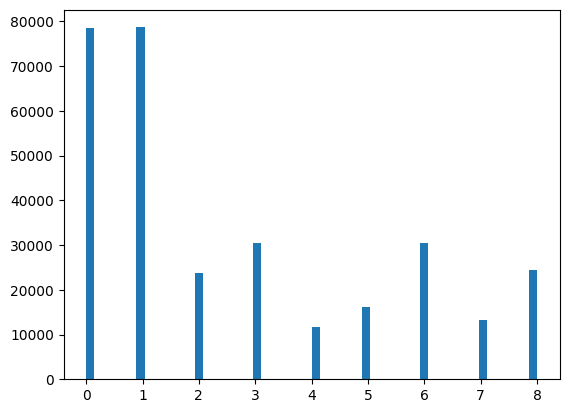

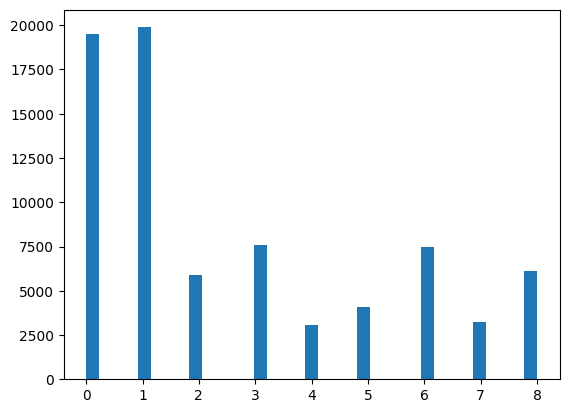

In [7]:
render_mask_histogram(y_train)
render_mask_histogram(y_test)

In [8]:
(patch, patch_label), rest_patch, rest_label = balance_classes(X_train, y_train, reduce=True, clustering=False)

In [9]:
X_train, y_train = [], []
X_train.append(patch)
X_train.append(rest_patch)
y_train.append(patch_label)
y_train.append(rest_label)
vegetation_indices = np.where(y_train[1] == 0)
X_train[1] = np.delete(X_train[1], vegetation_indices)
y_train[1] = np.delete(y_train[1], vegetation_indices)

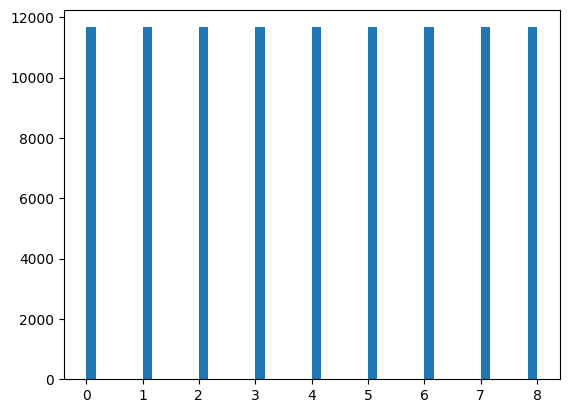

In [10]:
render_mask_histogram(y_train[0])

In [ ]:
network_type = 'allopezr_2d'
network_name = get_name(network_type)
num_classes = hc_set.get_num_classes()
img_shape = X_train[0][0].shape

X_train_flatten = get_center(X_train[0])

model = build_network(network_type=network_type, num_classes=num_classes, image_dim=img_shape)
compile_network(model, network_type, network_name, num_classes, show_summary=True, render_image=True)
history = run_model(model, [X_train[0], X_train_flatten], y_train[0], validation_split=validation_split, callbacks=get_callback_list(model_name=network_name))

{'optimizer': <keras.optimizers.optimizer_v2.rmsprop.RMSprop object at 0x00000230147EE130>, 'callbacks': [], 'intermediate_activation': 'relu', 'kernel_size': 3, 'start_size': 64, 'strides': 2}
Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_66 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 dense_45 (Dense)               (None, 121)          3751        ['input_66[0][0]']               
                                                                                                  
 input_65 (InputLayer)          [(None, 11, 11, 30)  0           []                               
                                ]                                                              

# Rendering and results

In [51]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss: " + str(test_loss) + ", Test Accuracy: " + str(test_accuracy))

ValueError: in user code:

    File "C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\keras\engine\training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\keras\engine\training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\keras\engine\training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\keras\engine\training.py", line 1665, in test_step
        y_pred = self(x, training=False)
    File "C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_29" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 11, 11, 30) dtype=float32>]


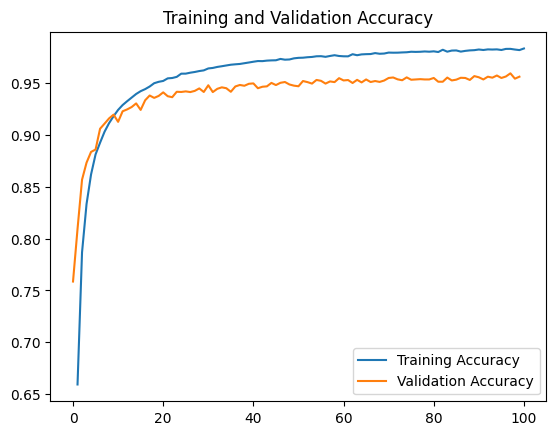

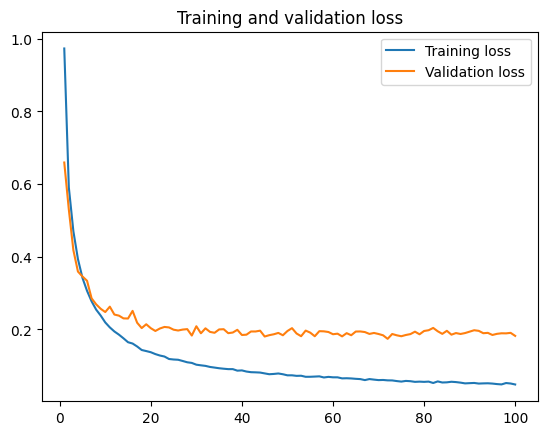

In [52]:
render_model_history(history, model_name=network_name, accuracy="sparse_categorical_accuracy")

2403/2403 [==============================] - 4s 2ms/step


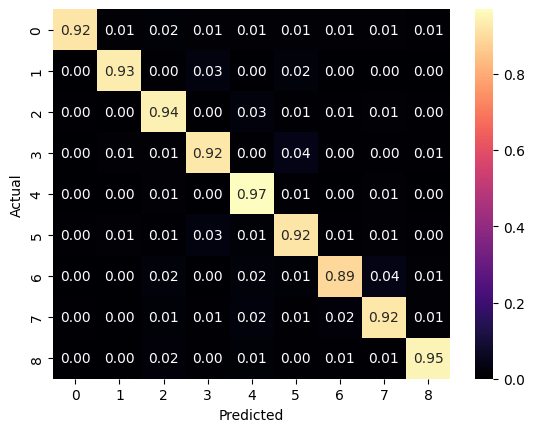

In [27]:
prediction = model.predict(X_test)
model_predictions = np.argmax(prediction, axis=1)
render_confusion_matrix(y_test, model_predictions)

3283/3283 [==============================] - 5s 1ms/step


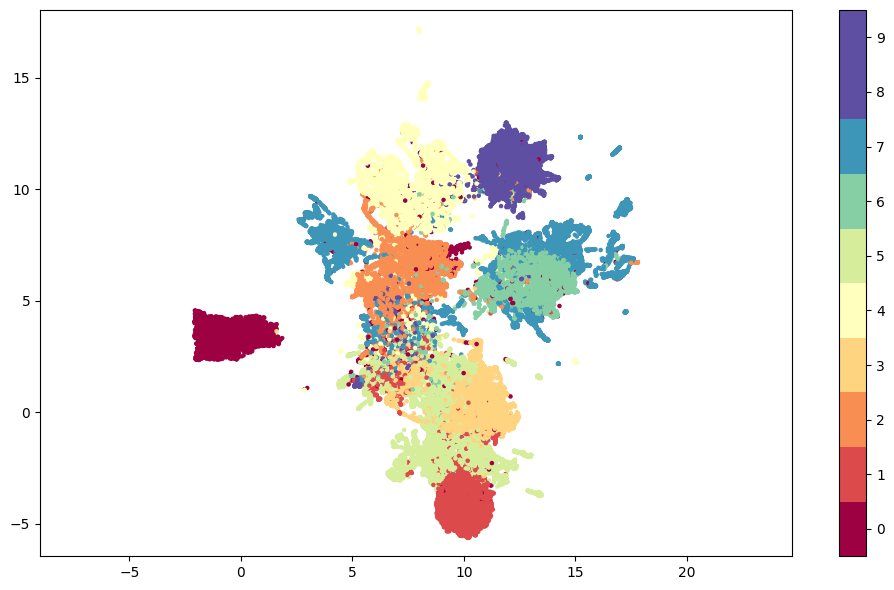

In [30]:
predict_model = keras.Model(model.input, model.layers[-2].output)
predicted_train = predict_model.predict(X_train[0])
render_umap_spectrum(predicted_train, y_train[0])